### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SBBSSBSB'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12246
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1627.0| 42.8975|-106.4636|       TMAX|USW00024089|    11|[00 4F 00 C6 00 7...|1949.0|SBBSSBSB|
|   1627.0| 42.8975|-106.4636|       TMAX|USW00024089|     3|[80 54 E0 50 00 7...|1950.0|SBBSSBSB|
|   1627.0| 42.8975|-106.4636|       TMAX|USW00024089|     6|[80 D1 00 CF 20 5...|1951.0|SBBSSBSB|
|   1627.0| 42.8975|-106.4636|       TMAX|USW00024089|     2|[40 D6 30 D5 40 D...|1952.0|SBBSSBSB|
|   1627.0| 42.8975|-106.4636|       TMAX|USW00024089|     0|[00 00 00 00 30 5...|1953.0|SBBSSBSB|
+---------+--------+---------+-----------+-----------+------+-------------

In [2]:
STAT

{'PRCP': {'Cov': array([[ 5.75533465,  1.89174948,  1.26186048, ...,  0.30467622,
           0.60106233,  0.74164174],
         [ 1.89174948,  6.28619253,  1.12010972, ...,  0.72988003,
           0.57374205,  0.52088082],
         [ 1.26186048,  1.12010972,  5.81394745, ...,  1.73663041,
           1.13696535,  0.74616111],
         ..., 
         [ 0.30467622,  0.72988003,  1.73663041, ...,  7.81237794,
           2.225366  ,  1.50688717],
         [ 0.60106233,  0.57374205,  1.13696535, ...,  2.225366  ,
           7.65221289,  2.00310265],
         [ 0.74164174,  0.52088082,  0.74616111, ...,  1.50688717,
           2.00310265,  6.544021  ]]),
  'E': array([ 1938.23022461,  2000.10180664,  1870.65722656,  2043.00024414,
          2668.78979492,  1880.95751953,  1752.99169922,  2615.76953125,
          2336.05151367,  2521.75      ,  2687.22924805,  1956.67211914,
          1737.52685547,  2107.92480469,  2479.88598633,  2593.27514648,
          2258.65185547,  1883.09716797,  1740.

### Select data for a particular station and measurement type

In [3]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USW00024089')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='PRCP' and station='USW00024089'
64 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1627.0| 42.8975|-106.4636|       PRCP|USW00024089|     0|[00 00 00 48 90 5...|1949.0|SBBSSBSB|
|   1627.0| 42.8975|-106.4636|       PRCP|USW00024089|     0|[00 00 60 51 00 4...|1950.0|SBBSSBSB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(64, 365)

### Script for plotting yearly plots

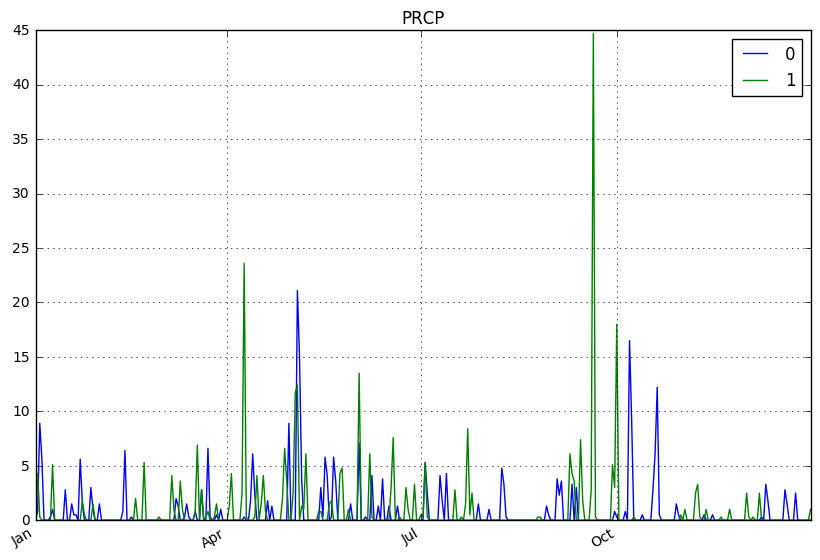

In [4]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='PRCP')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [5]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

/Users/federicorodriguez/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


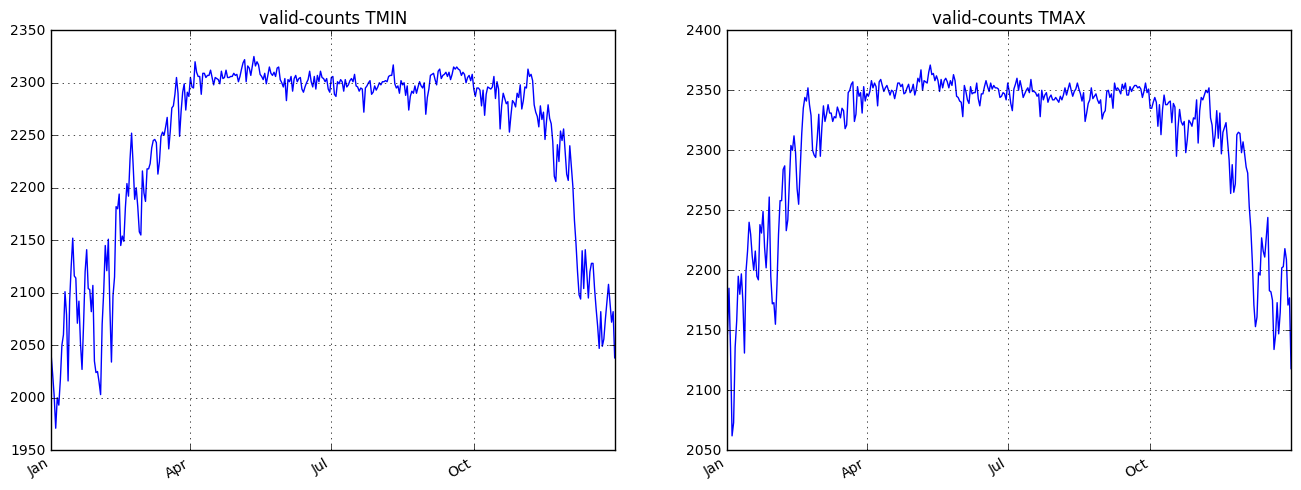

In [6]:
plot_pair(['TMIN','TMAX'],plot_valid)

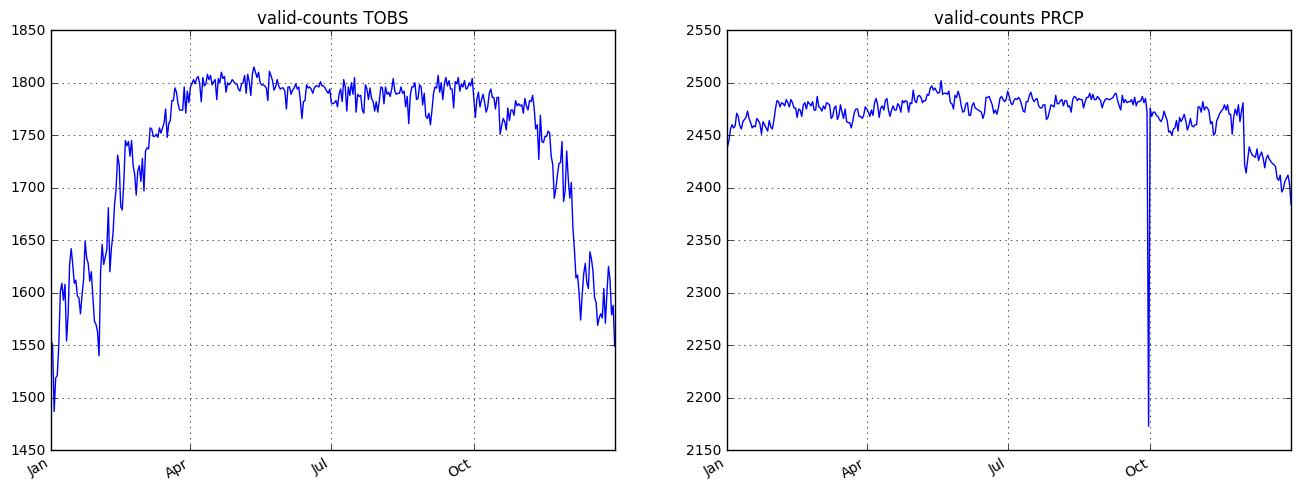

In [7]:
plot_pair(['TOBS','PRCP'],plot_valid)

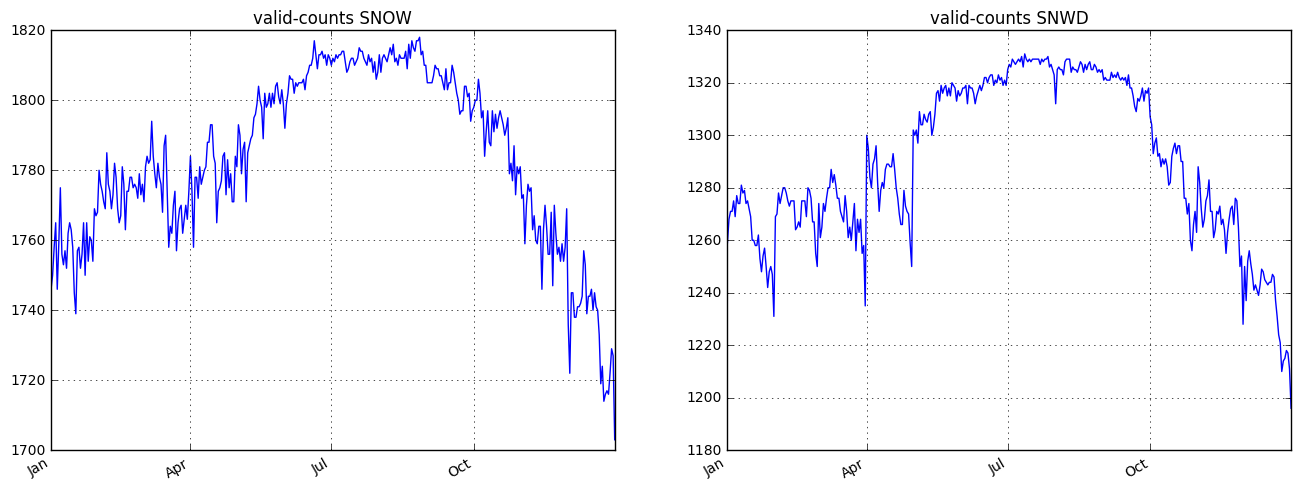

In [8]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [9]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

In [21]:
def plot_mean_std_metric(m,fig,axis):
    mean=STAT[m]['Mean'] * 25.4
    std=np.sqrt(STAT[m]['Var']) * 25.4
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

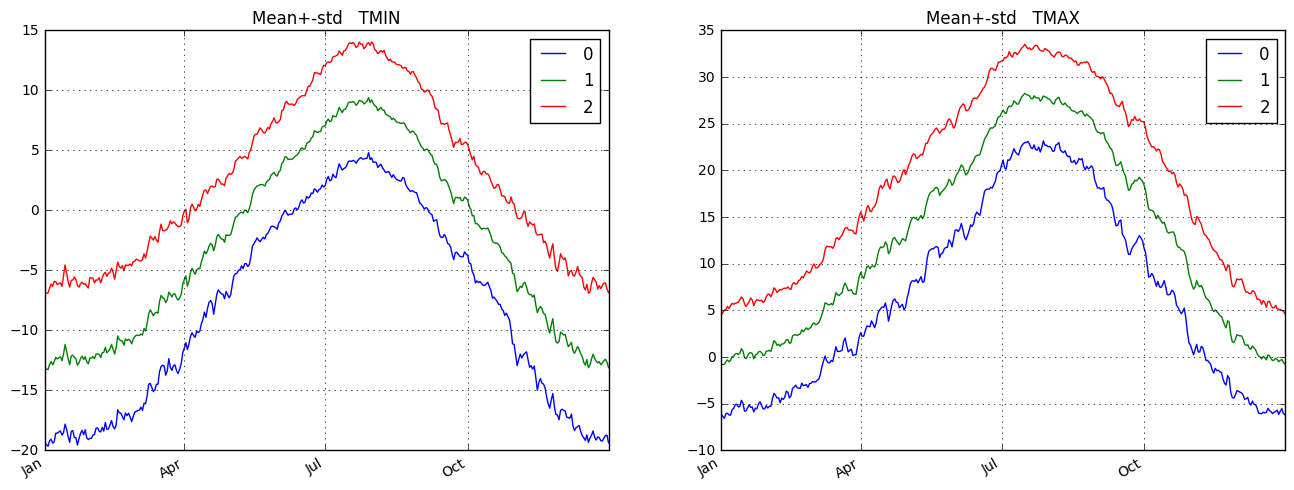

In [10]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

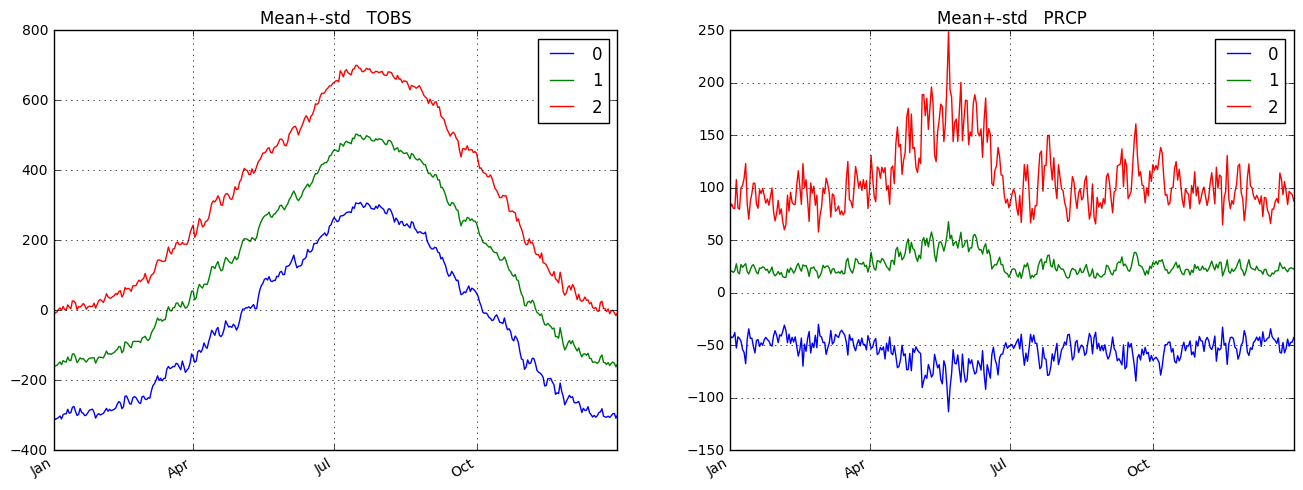

In [22]:
plot_pair(['TOBS','PRCP'],plot_mean_std_metric)

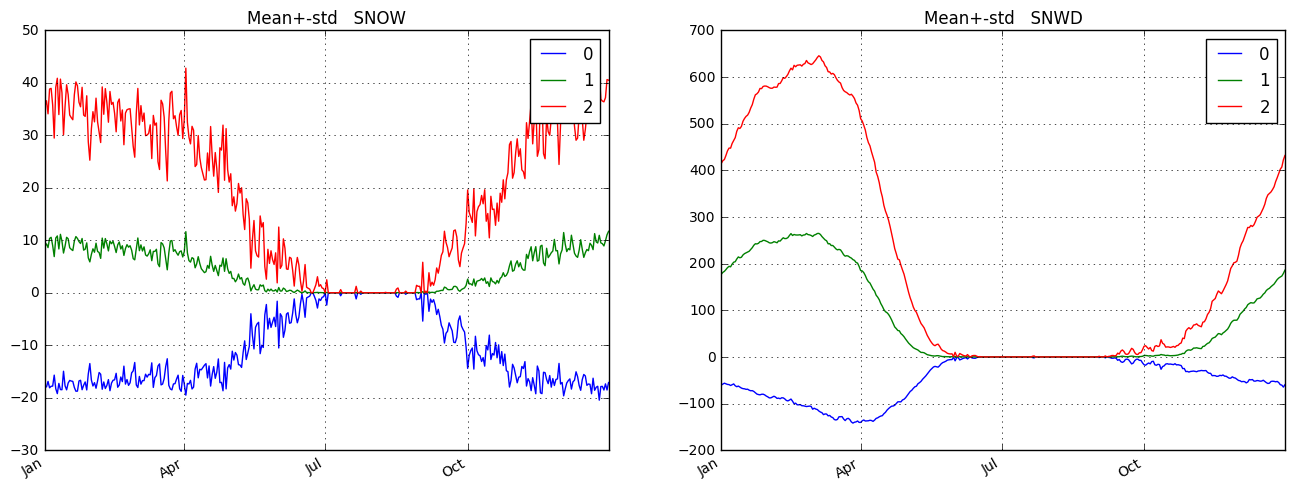

In [12]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### plotting top 3 eigenvectors

In [13]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

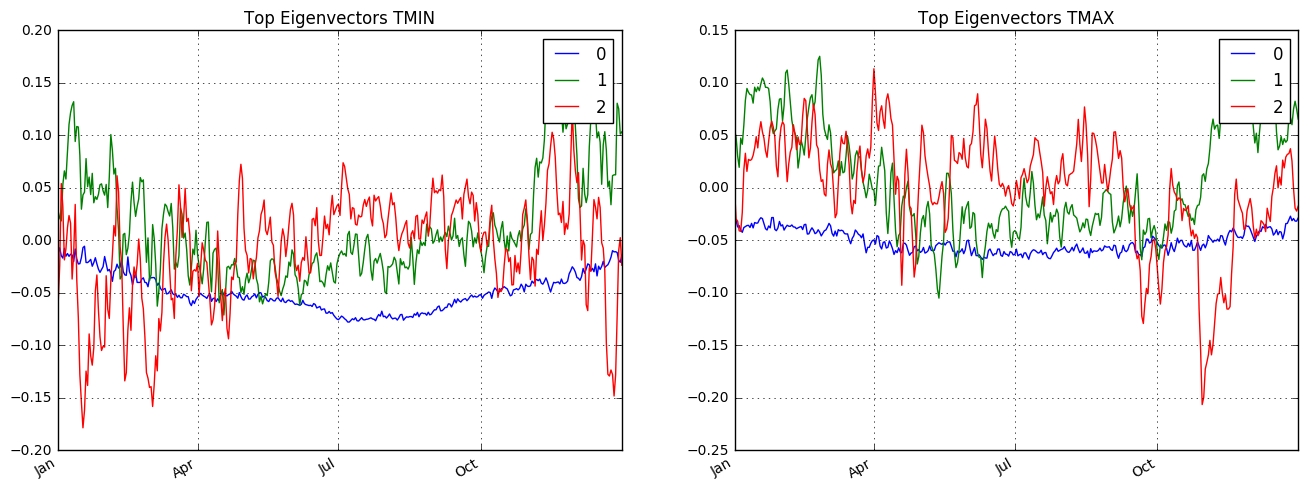

In [14]:
plot_pair(['TMIN','TMAX'],plot_eigen)

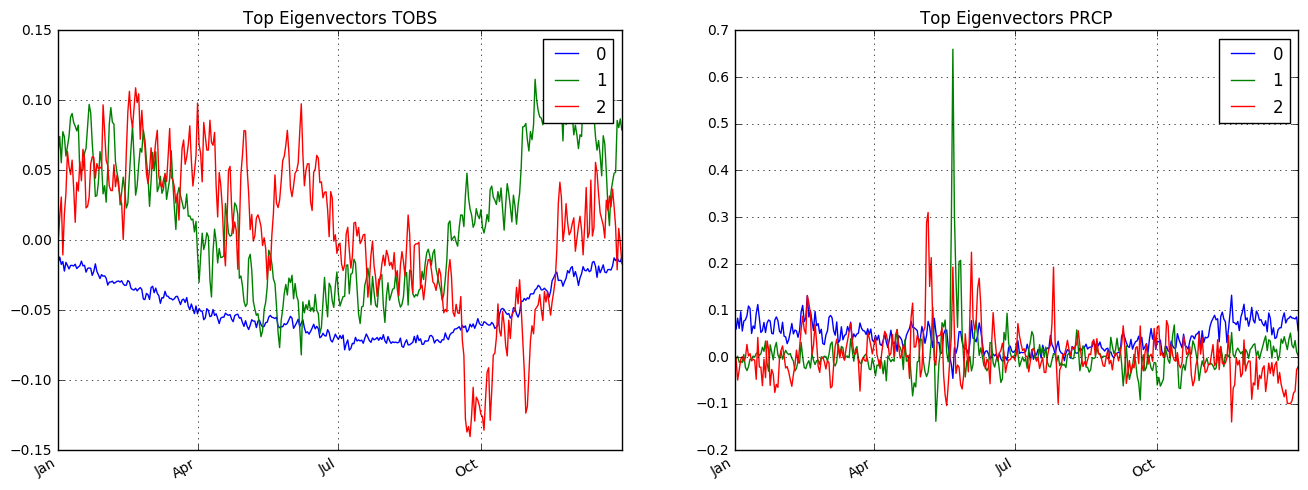

In [15]:
plot_pair(['TOBS','PRCP'],plot_eigen)

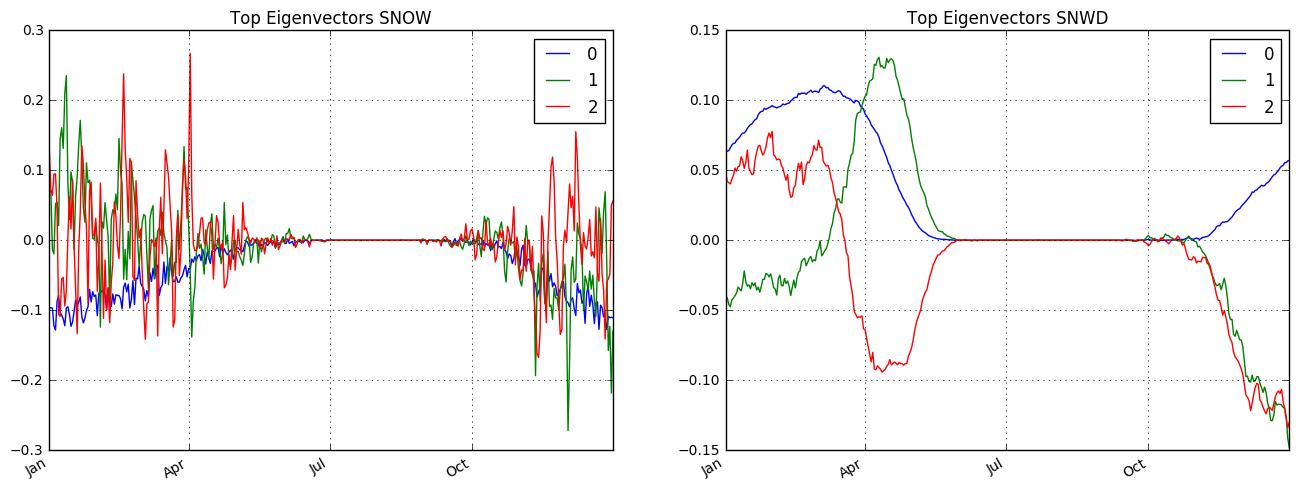

In [16]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [35]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

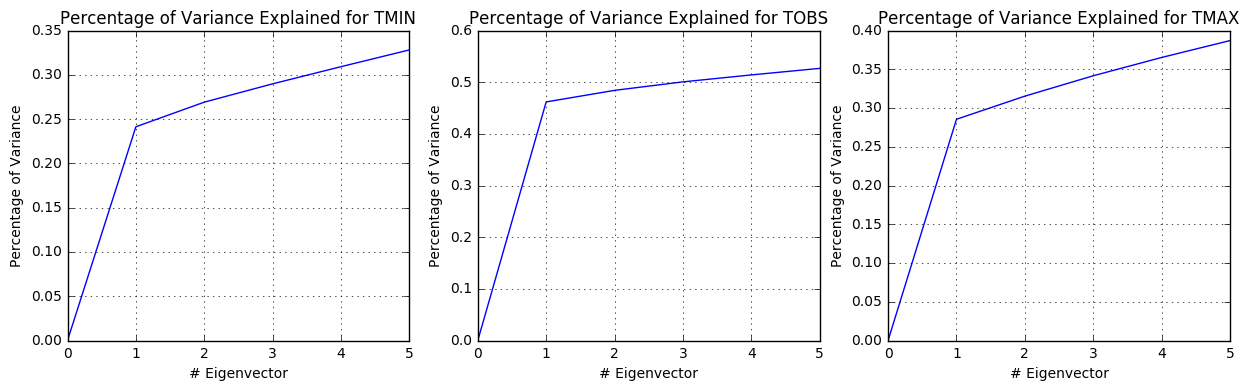

In [32]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

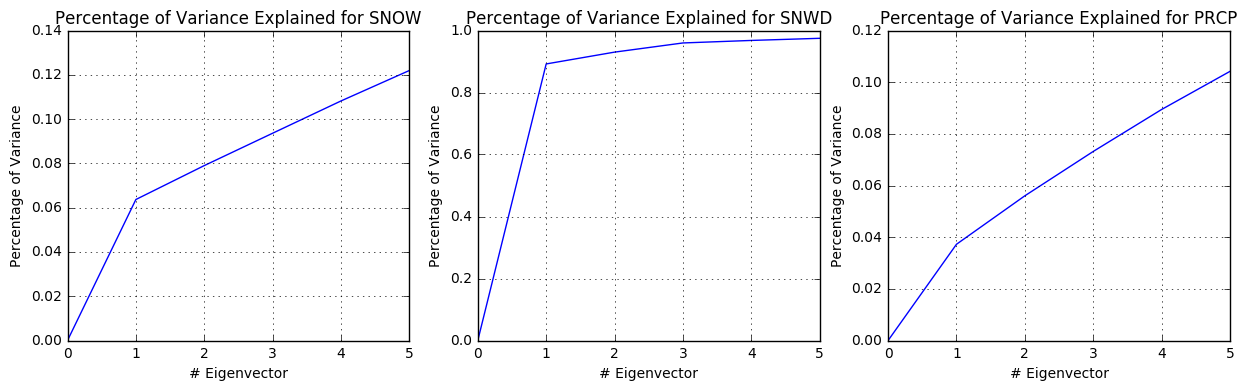

In [36]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [20]:
sc.stop()